
## GeostatsPy - GSLIB Reimplemented in Python 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

#### Prerequisites 

A computer capable of running Anaconda 3, Jupyter Notebook and DOS executables with the install completed as described below.  

#### Test Work Flow

This Jupyter Notebook in Python 3 is the test file for Geostatistics 2-Day Class.  Prior to the class complete the following tasks:

1. Install Anaconda 3 from https://www.anaconda.com/download/, select the Python 3.6 version.
2. Make a convenient working directory.
3. Download the GSLIB executables from http://www.statios.com/Quick/gslib.html, select the the F90 executables in 64bit, save the .zip file and extract to your working directory.
4. Open this Jupyter notebook.
5. Execute this notebook.  Let the instructor know if you run into issues (mpyrcz@austin.utexas.edu).   

#### Project Goal

Provide tools and workflows to make subsurface modeling workflows in Python using the robust, well-known Geostatistical Library, GSLIB.

#### Caveats

I included methods that I have found useful for building my geo-engineering workflows for subsurface modeling and should be accessible to most geoscientists and engineers.  Certainly, there are more advanced, more compact, more efficient methods to accomplish the same tasks.  I tried to keep the methods simple.  I appreciate feedback and I will use it to improve this tutorial periodically.

#### Load the required libraries

The following code loads the required libraries.


In [45]:
import os                                                   # set current working directory 
import numpy as np                                          # ndarrays
import pandas as pd
import matplotlib.pyplot as plt                             # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

The current state of PyThese are the functions we have included here:

1. GSLIB2Dataframe - load GSLIB Geo-EAS data tables to Pandas *DataFrame*
2. DataFrame2GSLIB - save Pandas *DataFrame* to GSLIB Geo-EAS data tables
3. GSLIB2ndarray - load GSLIB Geo-EAS format regular grid data 1D or 2D to NumPy *ndarray*
4. ndarray2GSLIB - write NumPy array to GSLIB Geo-EAS format regular grid data 1D or 2D
5. hist - histograms plots reimplemented with GSLIB parameters using python methods
6. pixelplt - plot 2D NumPy arrays with same parameters as GSLIB's pixelplt 
7. locmap - location maps reimplemented with GSLIB parameters using python methods
8. vargplt - variogram visualizer
9. gam_2d -regularly sampled data variograms
10. gamv_2d - irregularly sampled data variograms
11. vmodel_2d - variogram map calculator from gridded data
12. vmodelv_2d - variogram map calculator from iregularly sampled data
13. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
14. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods
15. nscore - normal score transform (data transformation to Gaussian with a mean of zero and a standard deviation of one)
16. declus - cell-ased declustering
17. sgsim - sequantial Gaussian simulation limited to 2D and unconditional

Warning, there has been no attempt to make these functions robust in the precense of bad inputs.  If you get a crazy error check the inputs.  Are the arrays the correct dimension?  Is the parameter order mixed up?  Make sure the inputs are consistent with the descriptions in this document.

In [46]:
# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    import os
    import numpy as np  
    import pandas as pd

    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# utility to convert pandas DataFrame to a GSLIB Geo-EAS file for use with GSLIB methods
def Dataframe2GSLIB(data_file,df):
    colArray = []
    colArray = df.columns
    ncol = len(df.columns) 
    nrow = len(df.index)
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write(str(ncol) + '\n') 
    for icol in range(0, ncol): 
        file_out.write(df.columns[icol]  + '\n')  
    
    for irow in range(0, nrow):
        for icol in range(0, ncol):
            file_out.write(str(df.iloc[irow,icol])+ ' ')  
        file_out.write('\n')

    file_out.close()      
    
# utility to convert GSLIB Geo-EAS files to a numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny):
    import os
    import numpy as np  

    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)
        
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]
        for iy in range(0,ny):
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ny-1-iy][ix] = head[0].split()[kcol]
    return array,col_name

# utility to convert numpy ndarray to a GSLIB Geo-EAS file for use with GSLIB methods   
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()
      
# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')    
    plt.show()
    return       
        
# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

def vargplt(lag,gamma,npair,vtype,name,xmin,xmax,ymin,ymax,sill,title,cmap):
    plt.figure(figsize=(8,6))
    marker = ["o","v","s","h","^",">","<"]
    if vtype==0:
        im = plt.scatter(lag,gamma,s=None, c=npair, marker=None, label = name,cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    else:
        plt.plot(lag,gamma,'C3',lw=3,c='black')
    ixy = 0 
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel('Lag Distance (m)')
    plt.ylabel('Variogram')
    plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
    plt.legend(loc = 'lower right')
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label('Number of Pairs', rotation=270, labelpad=20)
    plt.show()
    return im

def vargplts(lag,gamma,npair,vtype,name,xmin,xmax,ymin,ymax,sill,title,cmap):
    plt.figure(figsize=(8,6))
    marker = ["o","v","s","h","^",">","<"]
    nvar = lags.shape[0]
    for ivar in range(0, nvar):
        if vtype[ivar]==0:
            im = plt.scatter(lag[ivar],gamma[ivar],s=None,label = name[ivar],c=npair[ivar], marker=marker[ivar], cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
        else:
            plt.plot(lag[ivar],gamma[ivar], 'C3', lw=3,c='black')
    ixy = 0 
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel('Lag Distance (m)')
    plt.ylabel('Variogram')
    plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
    plt.legend(loc = 'lower right')
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label('Number of Pairs', rotation=270, labelpad=20)
    plt.show()
    return im

# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gam_2d(array,nx,ny,hsiz,nlag,xlag,ylag,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    ndarray2GSLIB(array,"gam_out.dat","gam.dat")
    
    file = open("gam.par", "w")
    file.write("                  Parameters for GAM                                       \n")
    file.write("                  ******************                                       \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gam_out.dat           -file with data                                      \n")
    file.write("1   1   0             -   number of variables, column numbers              \n")
    file.write("-1.0e21     1.0e21    -   trimming limits                                  \n")
    file.write("gam.out               -file for variogram output                           \n")
    file.write("1                     -grid or realization number                          \n")
    file.write(str(nx) + " 0.0 " + str(hsiz) + "  -nx, xmn, xsiz                           \n")
    file.write(str(ny) + " 0.0 " + str(hsiz) + "  -ny, ymn, ysiz                           \n")
    file.write(" 1   0.5   1.0        -nz, zmn, zsiz                                       \n")
    file.write("1 " + str(nlag) + "   -number of directions, number of lags                \n")
    file.write(str(xlag) + " " + str(ylag) + " 0 -ixd(1),iyd(1),izd(1)                     \n")
    file.write("1                     -standardize sill? (0=no, 1=yes)                     \n")
    file.write("1                     -number of variograms                                \n")
    file.write("1   1   1             -tail variable, head variable, variogram type        \n") 
    file.close()
    
    os.system('gam.exe gam.par')
    reading = True
    with open("gam.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                npair.append(float(head[0].split()[3]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gamv_2d(df,xcol,ycol,vcol,nlag,lagdist,azi,atol,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':rand_sample[vcol]})
    Dataframe2GSLIB("gamv_out.dat",df_ext)
    
    file = open("gamv.par", "w")
    
    file.write("                  Parameters for GAMV                                      \n")
    file.write("                  *******************                                      \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gamv_out.dat                    -file with data                            \n") 
    file.write("1   2   0                         -   columns for X, Y, Z coordinates      \n")
    file.write("1   3   0                         -   number of variables,col numbers      \n")
    file.write("-1.0e21     1.0e21                -   trimming limits                      \n")
    file.write("gamv.out                          -file for variogram output               \n")
    file.write(str(nlag) + "                      -number of lags                          \n")
    file.write(str(lagdist) + "                       -lag separation distance                 \n")
    file.write(str(lagdist*0.5) + "                   -lag tolerance                           \n")
    file.write("1                                 -number of directions                    \n")
    file.write(str(azi) + " " + str(atol) + " 99999.9 0.0  90.0  50.0  -azm,atol,bandh,dip,dtol,bandv \n")
    file.write(str(bstand) + "                    -standardize sills? (0=no, 1=yes)        \n")
    file.write("1                                 -number of variograms                    \n")
    file.write("1   1   1                         -tail var., head var., variogram type    \n")
    file.close()
    
    os.system('gamv.exe gamv.par')
    reading = True
    with open("gamv.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                npair.append(float(head[0].split()[3]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# irregular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmapv_2d(df,xcol,ycol,vcol,nx,ny,lagdist,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':rand_sample[vcol]})
    Dataframe2GSLIB("varmap_out.dat",df_ext)
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   3                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("0                            -1=regular grid, 0=scattered values           \n")
    file.write(" 50   50    1                -if =1: nx,     ny,   nz                      \n")
    file.write("1.0  1.0  1.0                -       xsiz, ysiz, zsiz                      \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nx) + " " + str(ny) + " 0 " + "-nxlag, nylag, nzlag                     \n")
    file.write(str(lagdist) + " " + str(lagdist) + " 1.0              -dxlag, dylag, dzlag \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nx*2+1; nny = ny*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nx)+0.5)*lagdist); xmin = -1*xmax; 
    ymax = ((float(ny)+0.5)*lagdist); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,lagdist,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  

# regular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmap_2d(array,nx,ny,hsiz,nlagx,nlagy,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
     
    ndarray2GSLIB(array,"varmap_out.dat","gam.dat")
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   1                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("1                            -1=regular grid, 0=scattered values           \n")
    file.write(str(nx) + " " + str(ny) + " 1  -if =1: nx,     ny,   nz                     \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0  - xsiz, ysiz, zsiz                     \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nlagx) + " " + str(nlagy) + " 0 " + "-nxlag, nylag, nzlag               \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0              -dxlag, dylag, dzlag       \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nlagx*2+1; nny = nlagy*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nlagx)+0.5)*hsiz); xmin = -1*xmax; 
    ymax = ((float(nlagy)+0.5)*hsiz); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,hsiz,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  

# variogram model, 2D wrapper for vmodel from GSLIB (.exe must be in working directory)
def vmodel_2d(nlag,step,azi,nug,nst,tstr1,c1,azi1,rmaj1,rmin1,tstr2=1,c2=0,azi2=0,rmaj2=0,rmin2=0):
    import os
    import numpy as np

    lag = []; gamma = []
    
    file = open("vmodel.par", "w")
    file.write("                                                                           \n")
    file.write("                  Parameters for VMODEL                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("vmodel.var                   -file for variogram output                    \n")
    file.write("1 " + str(nlag) + "          -number of directions and lags                \n")
    file.write(str(azi) + " 0.0 " + str(step) + " -azm, dip, lag distance                  \n")
    file.write(str(nst) + " " + str(nug) + " -nst, nugget effect                           \n")
    file.write(str(tstr1) + " " + str(c1) + " " + str(azi1) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj1) + " " + str(rmin1) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.write(str(tstr2) + " " + str(c2) + " " + str(azi2) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj2) + " " + str(rmin2) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.close()
    
    os.system('vmodel.exe vmodel.par')
    reading = True
    with open("vmodel.var") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma)  

# pixelplt with location map superimposed, reimplementation in Python of a MOD from GSLIB with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step)) 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.xlim(xmin,xmax-step)
    plt.ylim(ymin+step,ymax) 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return cs

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)            

# normal score transform, wrapper for nscore from GSLIB (.exe must be in working directory)(not used in this demo)   
def nscore(x):
    import os
    import numpy as np
    file = 'nscore_out.dat'
    ndarray2GSLIB(x,"nscore.dat","value")
    
    file = open("nscore.par", "w")
    file.write("                  Parameters for NSCORE                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("nscore.dat           -file with data                                       \n")
    file.write("1   0                    -  columns for variable and weight                \n")
    file.write("-1.0e21   1.0e21         -  trimming limits                                \n")
    file.write("0                        -1=transform according to specified ref. dist.    \n")
    file.write("../histsmth/histsmth.out -  file with reference dist.                      \n")
    file.write("1   2                    -  columns for variable and weight                \n")
    file.write("nscore.out               -file for output                                  \n")
    file.write("nscore.trn               -file for output transformation table             \n")
    file.close()

    os.system('nscore.exe nscore.par')
    file_in = 'nscore.out'
    y,name = GSLIB2ndarray('nscore.out',1,nx,ny)
    return(y)

# cell-based declustering, 2D wrapper for declus from GSLIB (.exe must be in working directory)
def declus(df,xcol,ycol,vcol,cmin,cmax,cnum,bmin):
    import os
    import numpy as np
    nrow = len(df)
    weights = []
    file = 'declus_out.dat'
    file_out = open(file, "w")
    file_out.write('declus_out.dat' + '\n')  
    file_out.write('3' + '\n')  
    file_out.write('x' + '\n') 
    file_out.write('y' + '\n')
    file_out.write('value' + '\n')  
    for irow in range(0, nrow):
        file_out.write(str(df.iloc[irow][xcol])+' '+str(df.iloc[irow][ycol])+' '+str(df.iloc[irow][vcol])+' \n')        
    file_out.close()
    
    file = open("declus.par", "w")
    file.write("                  Parameters for DECLUS                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("declus_out.dat           -file with data                                   \n")
    file.write("1   2   0   3               -  columns for X, Y, Z, and variable           \n")
    file.write("-1.0e21     1.0e21          -  trimming limits                             \n")
    file.write("declus.sum                  -file for summary output                       \n") 
    file.write("declus.out                  -file for output with data & weights           \n")
    file.write("1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)    \n") 
    file.write(str(bmin) + "                -0=look for minimum declustered mean (1=max)   \n") 
    file.write(str(cnum) + " " + str(cmin) + " " + str(cmax) + " -number of cell sizes, min size, max size      \n")
    file.write("5                           -number of origin offsets                      \n")
    file.close()
    
    os.system('declus.exe declus.par')
    df = GSLIB2Dataframe("declus.out")
    for irow in range(0, nrow):
        weights.append(df.iloc[irow,3])    

    return(weights)              
               
# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file):
    import os
    import numpy as np 
    
    hmn = hsiz * 0.5   
    hctab = int(hrange1/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(hrange1) + " " + str(hrange2) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write("1    0.0                      -nst, nugget effect                          \n")
    file.write("1    1.0 " + str(azi) + " 0.0 0.0 -it,cc,ang1,ang2,ang3                    \n")
    file.write(" " + str(hrange1) + " " + str(hrange2) + " 1.0 -a_hmax, a_hmin, a_vert     \n")
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array)

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[iy,ix]);y.append(yy[iy,ix]); v.append(array[iy,ix])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

# extract random set of samples from a model   
def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    ny = xx.shape[0]
    nx = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[iy,ix])
        y.append(yy[iy,ix])
        v.append(array[iy,ix])
   
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)  




#### Set the working directory

Set the working directory to the location that you have extracted the GSLIB executables.  

Aside, for all my workfowls I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see below) data file in this directory.  When we are done with this tutorial we will write our new dataset back to this directory.  

In [47]:
os.chdir("c:/PGE337")                                       # set the working directory

#### The Test Workflow

This is a set of tests to ensure that the configuration of your laptop and software installations are correct.  This is not a consistent workflow or demonstation of a besst practice; therefore, there will be very little explanation for brevity.  

#### Make Data by Geostatistical Simulation

We will make a 2D simulation and then extract data from it for testing.

In [48]:
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 74073                                                     # random number seed  for stochastic simulation    
range_max = 1800; range_min = 500; azimuth = 65                  # Porosity variogram ranges and azimuth
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
#cmap = plt.cm.RdYlBu
vmin = 4; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

# calculate a stochastic realization with standard normal distribution
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,range_max,range_min,azimuth,"simulation")
sim = affine(sim,mean,stdev)  

#### Gaussian Transform

Transform the simulated property to a standard normal Gaussian distribution.

In [49]:
nscore_sim = nscore(sim)

#### Histogram Plotting

Plot the histogram of the transformed realization.

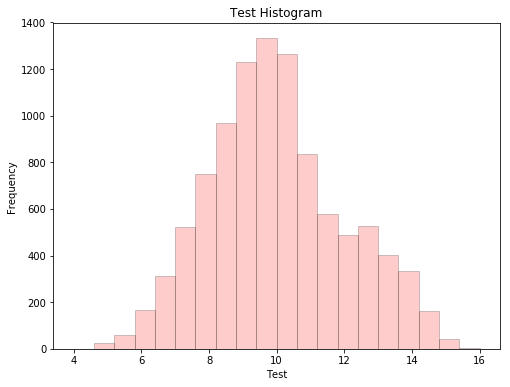

In [50]:
hist(sim.flatten(),vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Test",title="Test Histogram")

#### Gridded Data Visualization

Plot the 2D simulated model

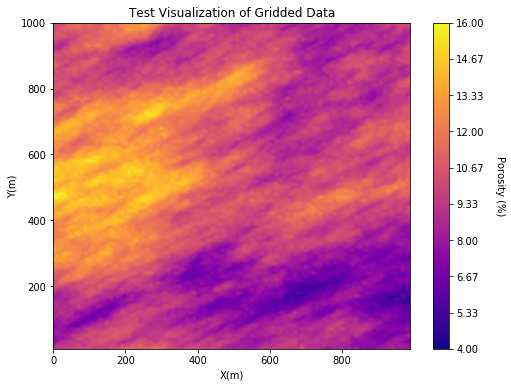

In [51]:
pixelplt(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Test Visualization of Gridded Data","X(m)","Y(m)","Porosity (%)",cmap)

#### Calculate Variogram

Calculate the variogram from 2D simulation

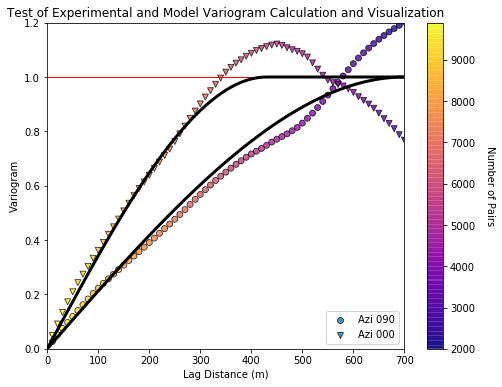

In [52]:
nlag = 70; standardize = 1                                        # set the variogram parameters
xlag = 1; ylag = 0;                                               # calculate the variograms in the x and y direcion
lag_x,gamma_x,npair_x = gam_2d(sim,nx,ny,cell_size,nlag,xlag,ylag,standardize)
xlag = 0; ylag = 1;
lag_y,gamma_y,npair_y = gam_2d(sim,nx,ny,cell_size,nlag+10,xlag,ylag,standardize)

lags = np.array([lag_x,lag_y])                                    # combine into in lists of arrays to pass to plotting
gammas = np.array([gamma_x,gamma_y])
npairs = np.array([npair_x,npair_y])
vtype = [0,0]                                                     # indicate that the two variograms are experimental
name = ['Azi 090','Azi 000']                                      # give the variograms names

lag_x_mod,gamma_x_mod = vmodel_2d(nlag=70,azi=90,step=10,nug=0,nst=1,tstr1=1,c1=1.0,azi1=90,rmaj1=700,rmin1=430)
lag_y_mod,gamma_y_mod = vmodel_2d(nlag=70,azi=0,step=10,nug=0,nst=1,tstr1=1,c1=1.0,azi1=90,rmaj1=700,rmin1=430)

lags = np.array([lag_x,lag_y,lag_x_mod,lag_y_mod])                # combine into in lists of arrays to pass to plotting
gammas = np.array([gamma_x,gamma_y,gamma_x_mod,gamma_y_mod])
npairs = np.array([npair_x,npair_y])
vtype = [0,0,1,1]                                                 # indicate that the two variograms are experimental
name = ['Azi 090','Azi 000','Model 090','Model 000']              # give the variograms names
vargplts(lags,gammas,npairs,vtype,name,0,700,0,1.2,1,"Test of Experimental and Model Variogram Calculation and Visualization",cmap)

#### Extract Samples from the Realization

Extract regular samples from the realization.

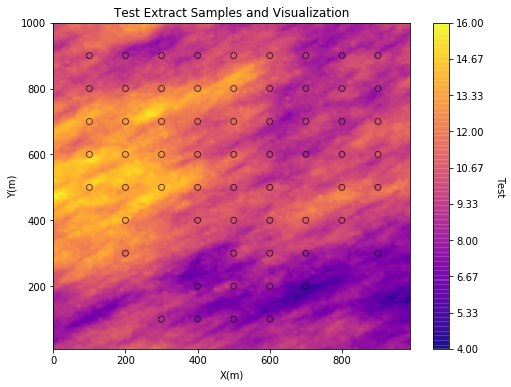

In [53]:
sampling_ncell = 10                                              # sample every 10th node from the model
samples = regular_sample(sim,xmin,xmax,ymin,ymax,sampling_ncell,10,10,'Realization')
samples_cluster = samples.drop([80,79,78,73,72,71,70,65,64,63,61,57,56,54,53,47,45,42]) # this removes specific rows (samples)
samples_cluster = samples_cluster.reset_index(drop=True)         # we reset and remove the index (it is not sequential anymore)

locpix(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,samples_cluster,'X','Y','Realization','Test Extract Samples and Visualization','X(m)','Y(m)','Test',cmap)

#### Save and Load Files

Save and load the samples and gridded data.

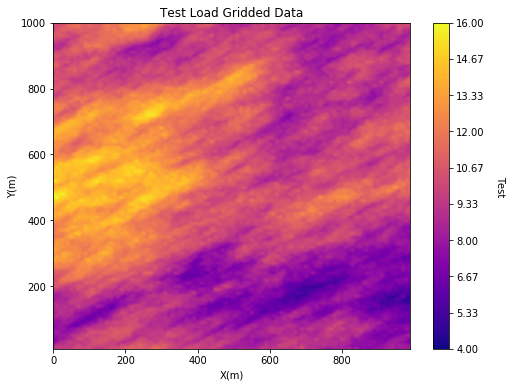

,X,Y,Realization
0,100.0,900.0,10.014587
1,200.0,900.0,8.700440
2,300.0,900.0,9.625546
3,400.0,900.0,8.889624
4,500.0,900.0,10.781195


In [54]:
ndarray2GSLIB(sim,"sim.dat","test_write")                        # write out 2D array to a Geo-DAS ASCII file
test_load,property_name = GSLIB2ndarray("sim.dat",0,nx,ny)       # read in 2D array from Geo-EAS file
pixelplt(test_load,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Test Load Gridded Data","X(m)","Y(m)","Test",cmap)

Dataframe2GSLIB("gslib.out",samples_cluster)
test_load_df = GSLIB2Dataframe("gslib.out")
test_load_df.head()

#### Test Complete

If the previous ran successfully then your system should be able use *GeostatsPy*.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On twitter I'm the @GeostatsGuy.
